# CS4220 Project 2 - Pathogen Detection

In this notebook, we give an example to show how to read and use the DNA read data. We will train one base line model, using `sklearn.LogisticRegression`, and use it to predict the pathogens in each patient's dataset.

## Related python packages

To get started (if you are using python), you may want to create a virtual python environment and install some packages. Here are some of the commands you might need:

```bash
conda create --name cs4220 python=3.8

# Install jupyter notebook if you are using it
conda install -c anaconda ipykernel
python -m ipykernel install --user --name=cs4220
conda install -c anaconda jupyter

# Some common packages
conda install pandas                      # for reading csv
conda install scikit-learn                # for the logistic regression model
pip install pytorch                       # if you are using neural networks
conda install -c conda-forge matplotlib   # for plotting
conda install seaborn                     # also for plotting
pip install umap-learn[plot]              # plotting UMAP plots
conda install numpy                       # for many math/vectorized operations
```

In [1]:
# import packages

import numpy as np
import pandas as pd
import timeit
import time
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pickle as pkl
from umap.umap_ import UMAP


/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import datashader as ds
import datashader.transfer_functions as tf
import datashader.bundling as bd
import colorcet
import matplotlib.cm
import bokeh.plotting as bpl
import bokeh.transform as btr
import holoviews as hv
import holoviews.operation.datashader as hd

In [3]:
import umap.plot
import torch

In [4]:
# Check the current working directory

%pwd

'/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection'

## Parsing Input Data

First, some dataset statistics. We load our training labels (ground truth) and see how many reads a category (species) have.

In [5]:
label_df = pd.read_csv('./training_data/train_labels.csv')
print(sum(label_df['species_name'].value_counts()))
label_df['species_name'].value_counts()

461581


species_name
decoy                              413476
burkholderia_pseudomallei            3533
pseudomonas_aeruginosa               3126
klebsiella_michiganensis             2989
mycobacterium_ulcerans               2910
klebsiella_pneumoniae                2806
serratia_liquefaciens                2629
vibrio_parahaemolyticus              2579
salmonella_enterica_typhimurium      2507
yersinia_enterocolitica              2276
stenotrophomonas_maltophilia         2217
mycobacterium_tuberculosis           2175
clostridioides_difficile             2007
acinetobacter_baumannii              1964
legionella_pneumophila               1753
listeria_monocytogenes               1479
staphylococcus_aureus                1384
staphylococcus_pseudintermedius      1328
corynebacterium_ulcerans             1266
corynebacterium_diphtheriae          1194
streptococcus_suis                   1092
neisseria_gonorrhoeae                1087
streptococcus_agalactiae             1060
streptococcus_pneumon

It seems that we have a lot of decoy reads (decoy means sequencing reads from human or commensal species).

In [6]:
# snippet to load the grouth truth training labels and normalize the label predictions.
# your trained model will predict in this space (26 classes - pathogens and decoy)
le = preprocessing.LabelEncoder()
le.fit(label_df['species_name'].unique())
y_index = le.transform(label_df['species_name'].values)
label_df['labels'] = y_index
#this label_df will have label index instead of the actual class value

In [7]:
print(len(label_df['species_name'].unique()))
label_df

26


,species_name,labels
0,acinetobacter_baumannii,0
1,acinetobacter_baumannii,0
2,acinetobacter_baumannii,0
3,acinetobacter_baumannii,0
4,acinetobacter_baumannii,0
...,...,...
461576,decoy,6
461577,decoy,6
461578,decoy,6
461579,decoy,6


We are not training using the full dataset to provide a quick baseline here. Thus, we subsampled so that each category has 500 reads. Up to you to come up with interesting training strategies to use your full training dataset (or even your own datasets)!

In [8]:
samples_index = label_df.groupby('labels').sample(500).index
samples_index
#500 here means that there are at most 500 per label class
# find ways to reduce the sample size as there are >10000 samples

Index([ 1012,  1261,  1813,  1933,   883,  1723,  1198,  1676,  1517,  1854,
       ...
       47846, 46105, 46535, 47165, 48088, 47695, 47327, 47253, 47320, 46991],
      dtype='int64', length=13000)

In this project, we try to use canonical $k$-mer profiles to represent each read in the input. Here, we are using $k=6$ and consequently 2081 features (including 1 feature `IGNORE` for ambiguous $k$-mer) for each read. Read [this reference](https://bioinfologics.github.io/post/2018/09/17/k-mer-counting-part-i-introduction/) for more information.

To help you save time, we implemented a utility class `CS4220Dataset` that can
- take in raw reads as input (`.fasta`, `.fa` files), and turn them into $k$-mer profiles, or
- take in $k$-mer profile as input (`.npy` files),
- allow you to sample data or create $k$-mer profile on the fly (during training) to save memory.

In [9]:
# Load dictionary that maps k-mer to their corresponding index.
# A k-mer and its reverse complement are mapped to the same index.

import json

with open("./training_data/6-mers.json", 'r') as dict_file:
    canonical_kmer_dict = json.load(dict_file)

    
# help to do label encoding on the reads values we used for ML training

In [10]:
# We define a utility function here that turns sequences to their 6-mer profiles.
# This is to allow the fasta file to be converted to data simialr npy file

def sequence_to_kmer_profile(sequence : str, k : int = 6):
    """
    Return the k-mer profile of the input sequence (string)
    """
    res = np.zeros(len(set(canonical_kmer_dict.values()))) # values for the dict is the labels encoded for the reads
    for i in range(len(sequence) - k + 1): #iterate through all the kmers within the seqeunce
        k_mer = sequence[i:i + k]
        if k_mer in canonical_kmer_dict: #if found in the available dict
            res[canonical_kmer_dict[k_mer]] += 1 #index of the res will be the label encoded for the reads while the actual value will be the counts
        else:
            res[-1] += 1 #count those invalid reads

    res /= np.sum(res)
    return res

In [11]:
import torch
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader

class CS4220Dataset(Dataset):
    def __init__(self, data_file, label_df=None, k=6, samples_index=None, kmer_profile_on_the_fly=False, dtype=np.float32):
        """
        Dataset class to load large CS4220 sequence database.

        Args:
            - data_file (`str`): Can either be a *.fasta file if the input is raw reads, or *.npy file
                                 if the input is k-mer profile.
            - label_df (`pd.DataFrame` or `None`): A dataframe with "labels" column indicating the label
                                                   of the data (must match with data_file), or `None` if there is
                                                   no label (in the case of test sets).
            - k (`int`): The lengt of k-mer. We use 6 in this project.
            - samples_index (`List` or `None`): list of indices of data we sample from the data file. You
                                                can use this if the dataset is very large and can't fit in memory.
                                                set this to `None` if you want to use all the data.
            - kmer_profile_on_the_fly (`bool`): If input data_file is raw reads and this set to `True`,
                                                we will build k-mer profile on the fly. This is helpful if you want to
                                                alter the input sequences during training, or the k-mer profile can't fit in memory.
                                                Otherwise, we build k-mer profile in advance, which will speed up the
                                                training process.
            - dtype: type to store the k-mer profile. You may use, for example, `np.float32` for better precision,
                     or `np.float16` for smaller memory usage. If loaded from ".npy" file, it is always `np.float16`.
        """
        self.data_file = data_file

        if ".fasta" in data_file or ".fa" in data_file or ".fna" in data_file:
            self.is_raw_reads = True
        elif ".npy" in data_file:
            self.is_raw_reads = False
        else:
            raise TypeError(f"The input file must be either a fasta file containing raw reads (.fasta, .fa, .fna) or a numpy file containing k-mer profiles (.npy).")


        self.label_df = label_df
        self.kmer_profile_otf = kmer_profile_on_the_fly

        # k-mer length, set to be 6.
        self.k = k

        # the samples we take from the read dataset
        self.samples_index = samples_index

        self.dtype = dtype

        # Load the data and store in self.reads and self.labels
        self.X = []
        self.Y = []
        self._read_labels()
        self._read_data()
        


    def _read_labels(self):
        """
        Read the labels and record them in self.labels.
        """
        if self.label_df is None:
            self.Y = None
        elif self.samples_index is None:
            # Load the whole dataset
            self.Y = list(self.label_df["labels"])
        else:
            # Load only the data corresponding to the sampled index
            self.Y = list(self.label_df.iloc[self.samples_index]["labels"])


    def _read_data(self):
        if self.is_raw_reads:
            # Read the fasta file
            with open(self.data_file, 'r') as fasta_file:
                lines = fasta_file.readlines()

            read_range = self.samples_index if self.samples_index is not None else range(int(len(lines) / 2))
            if not self.kmer_profile_otf:
                self.X = np.zeros(
                    (len(read_range), len(set(canonical_kmer_dict.values()))),
                    dtype=self.dtype
                )

            for i, j in enumerate(tqdm(read_range, desc=f"Parsing fasta file {self.data_file}")):
                read = lines[j * 2 + 1].strip()
                if self.kmer_profile_otf:
                    # If chose to do k-mer profiling on the fly, simply store the reads
                    self.X.append(read)
                else:
                    # Otherwise, do k-mer profiling during training/testing, cost more time during training/testing
                    self.X[i, :] = sequence_to_kmer_profile(read, self.k)
        else:
            # Read the .npy file, and load the numpy matrix
            # Each row corresponds to a read, and each column corresponds to a k-mer (see training_data/6-mers.txt).
            self.X = np.load(self.data_file)
            if self.samples_index is not None:
                self.X = self.X[self.samples_index, :]

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        """
        If you are using pytorch, this function helps taking data points during each epoch
        of your training.
        """
        x = self.X[idx]
        if self.kmer_profile_otf:
            read_tensor = torch.tensor(sequence_to_kmer_profile(x, self.k), dtype=self.dtype)
        else:
            read_tensor = torch.tensor(x)

        label = self.Y[idx] if self.Y is not None else None
        return read_tensor, label


# Example usage
#input_file_path = './training_data/train_raw_reads.fasta'
input_file_path = './training_data/train_6mers.npy'

sampled_dataset = CS4220Dataset(input_file_path, label_df, samples_index=samples_index)
print(len(sampled_dataset.X[:, :-1]), len(sampled_dataset.X[:, :-1][0])) # each row represent the sequence and each featuere represent the unique k-mers profile and the values represent the frequencies to it; exclude the last col as that is ambiguous
print(len(sampled_dataset.Y))

13000 2080
13000


The data and labels are then accessible via `sampled_dataset.X` and `sampled_dataset.Y`.

## Quick Exploratory Data Analysis

We can use a [UMAP plot](https://www.scdiscoveries.com/blog/knowledge/what-is-a-umap-plot/) to try to group reads in the same species together, according to their $k$-mer profiles.

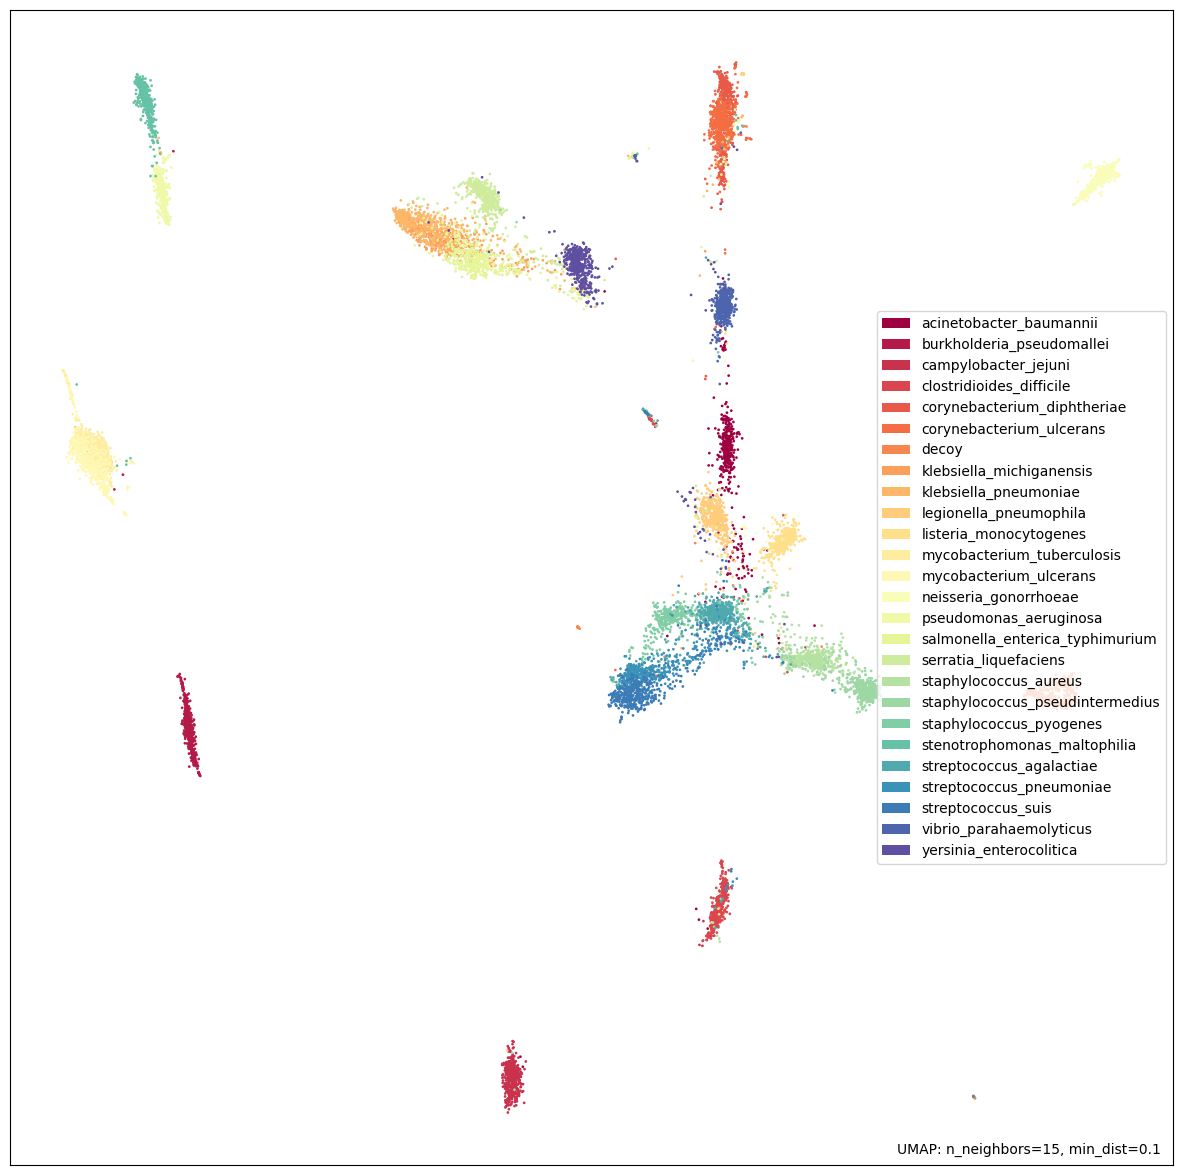

In [12]:
# the last column of our 6mer training dataset can be ignored
mapper = UMAP().fit(sampled_dataset.X[:, :-1])

labels_tc = le.inverse_transform(sampled_dataset.Y)
ax = umap.plot.points(mapper, labels=labels_tc,  width=1500, height=1500)

#### Just trying to integrate PCA into the UMAP to reduce the number of features and see if it cluster better but that doesn't seem to be the case 

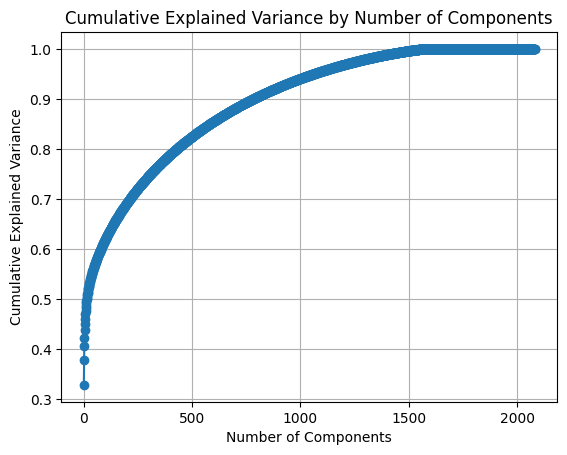

In [13]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2080)  # Use the maximum number of components
pca.fit(sampled_dataset.X[:, :-1])
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='-')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by Number of Components')
plt.grid(True)
plt.show()

In [15]:
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1
n_components_95

1060

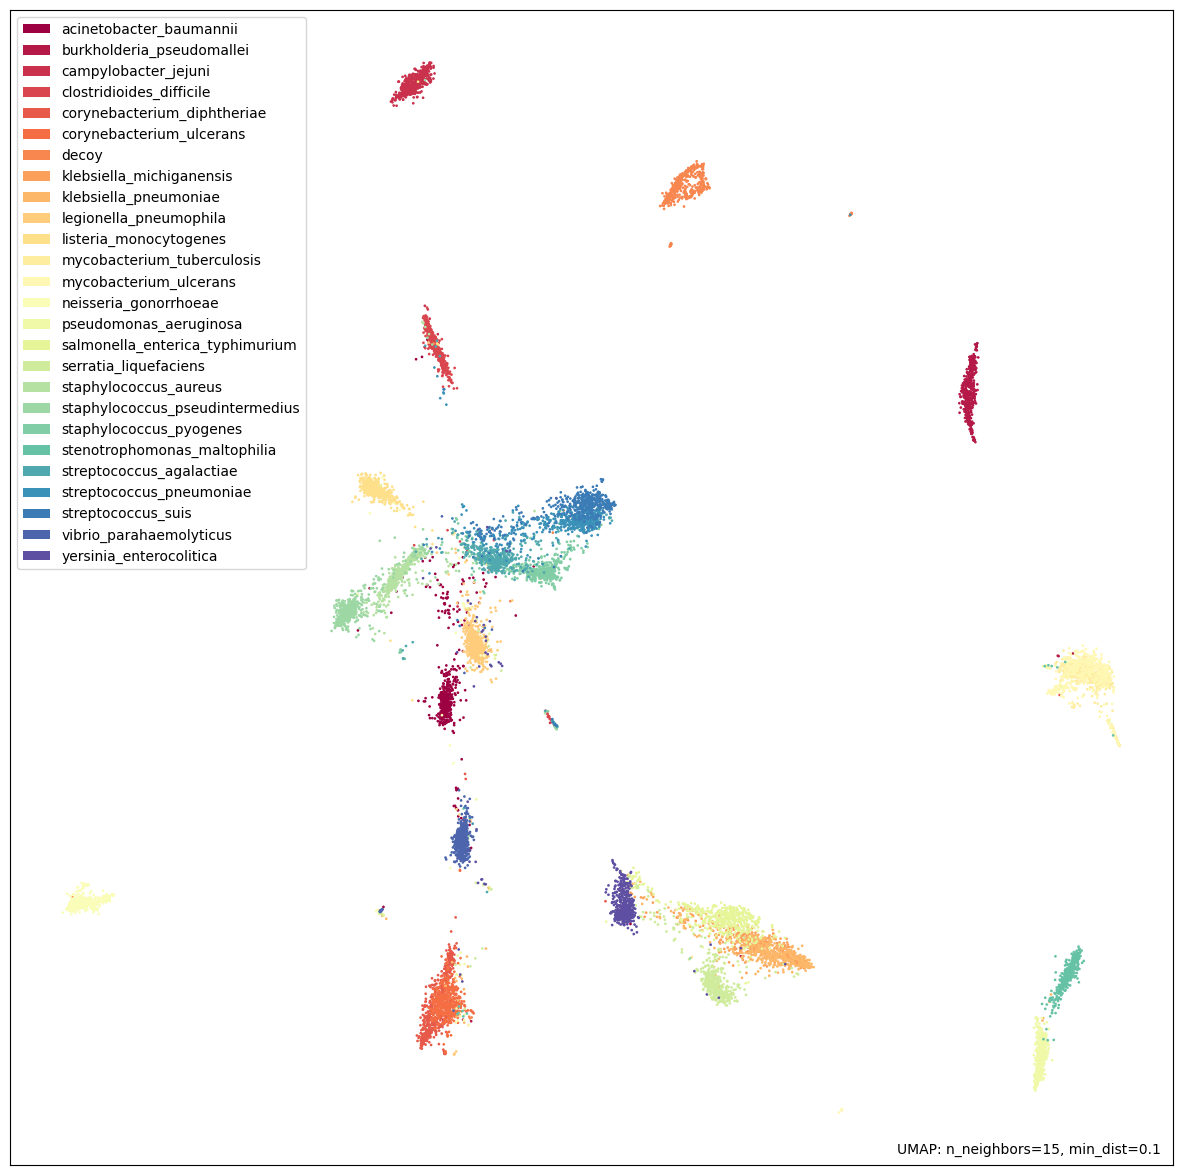

In [16]:
sampled_X=sampled_dataset.X[:, :-1]
pca = PCA(n_components=1060)  # Specify the number of components to keep
sampled_X_pca = pca.fit_transform(sampled_X)
mapper_pca = UMAP().fit(sampled_X_pca)
labels_tc_pca = le.inverse_transform(sampled_dataset.Y)
ax = umap.plot.points(mapper_pca, labels=labels_tc_pca,  width=1500, height=1500)

What interesting patterns can you notice? Some observations might be:
- Some species are pretty separated in clusters.
- Even though most species lie in separate groups, we can see some regions where points from different species are overlapping.
- There are some "lost points" for pretty much every species.

Do you think these pieces of information can help you in something? Think about it.

Eugene's take on it:
- certain species have distinct genomic or sequence profiles that differentiate them from other species in the dataset
- the overlapping regions suggest shared genomic sequence between closely related species
- The "lost points" refer to data points that do not clearly belong to any specific cluster or group in the UMAP plot.


## Training

OK, time for training. As baseline we will choose the simplest [logistic regression](https://en.wikipedia.org/wiki/Logistic_regression) model.

You can fine-tune the logistic regression hyperparameters such as the penalty and regularization term.

```python
from sklearn.model_selection import GridSearchCV

#list of items to tune
parameters_lr = [{'penalty': ['l1','l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100]}]

starting_time = timeit.default_timer()

regr = LogisticRegression(random_state=2023, solver='saga', n_jobs=-1, class_weight='balanced', max_iter=50, verbose=1)

grid_search_lr = GridSearchCV(estimator = regr,
                              param_grid = parameters_lr,
                              scoring = 'accuracy',
                              cv = 3,
                              n_jobs = -1)

# the last column of our 6mer training dataset can be ignored (training labels)
grid_search_lr.fit(sampled_dataset.X, sampled_dataset.Y)
best_accuracy_lr = grid_search_lr.best_score_
best_parameter_lr = grid_search_lr.best_params_

```

This might take a long time. Here, we skip this step and jump straight to training.

In [13]:
# linear classifier using scikit-learn
# Best Parameter of LR: {'C': 100, 'penalty': 'l1'}

starting_time = timeit.default_timer()

regr = LogisticRegression(C=100, penalty='l1', solver='saga', n_jobs=-1, class_weight='balanced', max_iter=500, verbose=1)
%timeit
# Train the model using the training sets
regr.fit(sampled_dataset.X, sampled_dataset.Y)
print("Time taken :", timeit.default_timer() - starting_time)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.32718872
Epoch 3, change: 0.21016617
Epoch 4, change: 0.15737595
Epoch 5, change: 0.12867449
Epoch 6, change: 0.11355869
Epoch 7, change: 0.09833634
Epoch 8, change: 0.08735577
Epoch 9, change: 0.07868494
Epoch 10, change: 0.07085578
Epoch 11, change: 0.06449740
Epoch 12, change: 0.05800981
Epoch 13, change: 0.05288937
Epoch 14, change: 0.04835291
Epoch 15, change: 0.04467417
Epoch 16, change: 0.04120685
Epoch 17, change: 0.03826334
Epoch 18, change: 0.03552199
Epoch 19, change: 0.03332514
Epoch 20, change: 0.03120125
Epoch 21, change: 0.02964244
Epoch 22, change: 0.02846154
Epoch 23, change: 0.02719851
Epoch 24, change: 0.02602620
Epoch 25, change: 0.02509118
Epoch 26, change: 0.02406029
Epoch 27, change: 0.02323446
Epoch 28, change: 0.02233156
Epoch 29, change: 0.02139020
Epoch 30, change: 0.02070084
Epoch 31, change: 0.02000347
Epoch 32, change: 0.01928746
Epoch 33, change: 0.01871938
Epoch 34, change: 0.01804103
Epoch 35, change: 0.017

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


We can now save our trained model for later usage. This is an example of how you can send your model to our final evaluation.

In [14]:
from joblib import dump, load
dump(regr, 'models/baseline.joblib')

['models/baseline.joblib']

### Trying out the GridSearchCV method he suggested but takes even longer and coef_ did not coverge as max_iter of 500 is reached

In [43]:
from sklearn.model_selection import GridSearchCV

#list of items to tune
parameters_lr = [{'penalty': ['l1','l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100]}]

starting_time = timeit.default_timer()

regr = LogisticRegression(random_state=2023, solver='saga', n_jobs=-1, class_weight='balanced', max_iter=500, verbose=1)

grid_search_lr = GridSearchCV(estimator = regr,
                              param_grid = parameters_lr,
                              scoring = 'accuracy',
                              cv = 3,
                              n_jobs = -1)

# the last column of our 6mer training dataset can be ignored (training labels)
grid_search_lr.fit(sampled_dataset.X, sampled_dataset.Y)
best_accuracy_lr = grid_search_lr.best_score_
best_parameter_lr = grid_search_lr.best_params_

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


rescaling...
rescaling...
rescaling...
rescaling...
rescaling...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
Epoch 2, change: 0.24605679
rescaling...
rescaling...
rescaling...
rescaling...
Epoch 2, change: 0.85174389
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
Epoch 2, change: 0.37143930
rescaling...
rescaling...
rescal

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
Epoch 3, change: 0.17044856
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
Epoch 3, change: 1.25201321
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
Epoch 3, change: 0.41483331
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
resc

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


rescaling...
rescaling...
Epoch 9, change: 0.00902019
rescaling...
rescaling...
rescaling...
Epoch 13, change: 0.00037753
Epoch 12, change: 0.00081007
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
Epoch 12, change: 0.00020948
rescaling...
Epoch 10, change: 0.00581035
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
Epoch 12, change: 0.00133987
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
convergence after 14 epochs took 30 seconds
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


rescaling...
rescaling...
Epoch 13, change: 0.00033501
rescaling...
rescaling...
Epoch 1, change: 1.00000000
rescaling...
rescaling...
rescaling...
convergence after 14 epochs took 31 seconds
rescaling...
Epoch 10, change: 0.12280481
Epoch 13, change: 0.00013980


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


rescaling...
rescaling...
convergence after 13 epochs took 28 seconds
Epoch 11, change: 0.00470547
rescaling...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


rescaling...
Epoch 1, change: 1.00000000
rescaling...
rescaling...
convergence after 14 epochs took 29 seconds


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


rescaling...
Epoch 1, change: 1.00000000
convergence after 14 epochs took 30 seconds
Epoch 2, change: 0.07222545


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 11, change: 0.02502041
Epoch 1, change: 1.00000000
Epoch 12, change: 0.00152338
Epoch 2, change: 0.14179457
Epoch 2, change: 0.14983781
Epoch 1, change: 1.00000000
Epoch 2, change: 0.30637309
Epoch 1, change: 1.00000000
Epoch 3, change: 0.23959403
Epoch 12, change: 0.00017965
Epoch 3, change: 0.15031017
Epoch 13, change: 0.00085472
Epoch 3, change: 0.16202048
Epoch 2, change: 0.23905113
Epoch 3, change: 0.21403650
Epoch 4, change: 0.04381833
Epoch 2, change: 0.29222344
Epoch 13, change: 0.00374735
Epoch 4, change: 0.08541080
Epoch 14, change: 0.05130536
Epoch 4, change: 0.04486655
Epoch 4, change: 0.05120443
Epoch 3, change: 0.16935010
Epoch 5, change: 0.04782048
Epoch 5, change: 0.11048341
Epoch 3, change: 0.15220164
Epoch 14, change: 0.00093229
Epoch 5, change: 0.03891307
Epoch 15, change: 0.02660019
Epoch 5, change: 0.02829420
Epoch 4, change: 0.13252198
Epoch 6, change: 0.01220067
Epoch 6, change: 0.05832446
Epoch 15, change: 0.00206643
Epoch 4, change: 0.12542226
Epoch 6, ch

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 10, change: 0.00652158
Epoch 8, change: 0.09090540
Epoch 11, change: 0.00258405
Epoch 10, change: 0.00421678
Epoch 8, change: 0.08811949
convergence after 19 epochs took 49 seconds
Epoch 10, change: 0.03822223


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 11, change: 0.00049236
Epoch 1, change: 1.00000000
Epoch 11, change: 0.00086953
Epoch 12, change: 0.00032978
Epoch 9, change: 0.08286189
Epoch 1, change: 1.00000000
Epoch 9, change: 0.08202451
Epoch 11, change: 0.01792334
Epoch 12, change: 0.00087867
convergence after 13 epochs took 28 seconds


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 2, change: 0.23541169
Epoch 12, change: 0.00029477
Epoch 10, change: 0.07506192
Epoch 2, change: 0.11204104
Epoch 13, change: 0.00065775
Epoch 12, change: 0.00424747
Epoch 10, change: 0.07665171
Epoch 1, change: 1.00000000
Epoch 13, change: 0.00029680
Epoch 3, change: 0.16625161
Epoch 3, change: 0.02231504
Epoch 11, change: 0.06821853
Epoch 14, change: 0.00042992
Epoch 13, change: 0.00430469
Epoch 2, change: 0.10202865
Epoch 11, change: 0.07011091
Epoch 14, change: 0.00020220
Epoch 4, change: 0.03810819
Epoch 4, change: 0.14190803
Epoch 12, change: 0.06283407
Epoch 15, change: 0.00016787
Epoch 3, change: 0.18892660
Epoch 12, change: 0.06446398
convergence after 15 epochs took 33 seconds
Epoch 14, change: 0.00133781


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 5, change: 0.01051865
Epoch 5, change: 0.12907323
convergence after 16 epochs took 36 seconds
Epoch 13, change: 0.05775695


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 4, change: 0.06677910
Epoch 1, change: 1.00000000
Epoch 15, change: 0.00019644
Epoch 6, change: 0.04506222
Epoch 13, change: 0.05918226
Epoch 5, change: 0.01231470
Epoch 6, change: 0.11420088
Epoch 14, change: 0.05360267
Epoch 2, change: 0.09522728
Epoch 7, change: 0.02993865
Epoch 16, change: 0.00212169
Epoch 1, change: 1.00000000
Epoch 14, change: 0.05481113
Epoch 6, change: 0.01730330
Epoch 7, change: 0.10630974
Epoch 3, change: 0.08573108
Epoch 15, change: 0.04961734
Epoch 8, change: 0.00362146
Epoch 17, change: 0.00290110
Epoch 15, change: 0.05103190
Epoch 7, change: 0.00918456
Epoch 4, change: 0.02682554
Epoch 8, change: 0.09573691
Epoch 9, change: 0.00409068
Epoch 2, change: 0.27519111
Epoch 16, change: 0.04613948
Epoch 8, change: 0.00328660
Epoch 16, change: 0.04756922
Epoch 18, change: 0.00120873
Epoch 5, change: 0.02510726
Epoch 10, change: 0.00187723
Epoch 9, change: 0.08535701
Epoch 17, change: 0.04324119
Epoch 9, change: 0.00138357
Epoch 6, change: 0.01523818
Epoch 1

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 9, change: 0.00121929
Epoch 12, change: 0.06435244
Epoch 14, change: 0.00957065
Epoch 20, change: 0.03581281
Epoch 13, change: 0.00039669
Epoch 20, change: 0.03691073
Epoch 5, change: 0.12187184
Epoch 10, change: 0.00592565
Epoch 13, change: 0.05901792
Epoch 15, change: 0.00507801
Epoch 21, change: 0.03380482
Epoch 1, change: 1.00000000
convergence after 14 epochs took 30 seconds


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 21, change: 0.03497195
Epoch 11, change: 0.00296934
Epoch 16, change: 0.00045764
Epoch 14, change: 0.05450068
Epoch 6, change: 0.10547127
Epoch 22, change: 0.03192297
Epoch 12, change: 0.00065046
Epoch 22, change: 0.03294957
Epoch 17, change: 0.00033761
Epoch 2, change: 0.32100287
Epoch 1, change: 1.00000000
Epoch 15, change: 0.05068344
Epoch 23, change: 0.03023638
Epoch 13, change: 0.00045931
Epoch 18, change: 0.00014685
Epoch 7, change: 0.09303740
Epoch 23, change: 0.03131394
Epoch 16, change: 0.04699683
Epoch 24, change: 0.02878340
Epoch 14, change: 0.00021780
convergence after 19 epochs took 42 seconds
Epoch 3, change: 0.18490885
Epoch 2, change: 0.27854596


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 24, change: 0.02965426
Epoch 8, change: 0.08500320
convergence after 15 epochs took 32 seconds
Epoch 17, change: 0.04397441
Epoch 25, change: 0.02728777


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 25, change: 0.02827063
Epoch 3, change: 0.19513073
Epoch 4, change: 0.14484332
Epoch 1, change: 1.00000000
Epoch 2, change: 0.25675190
Epoch 18, change: 0.04089527
Epoch 26, change: 0.02625504
Epoch 9, change: 0.07818012
Epoch 26, change: 0.02695644
Epoch 2, change: 0.28515729
Epoch 3, change: 0.16127407
Epoch 19, change: 0.03861420
Epoch 27, change: 0.02532790
Epoch 4, change: 0.15522492
Epoch 5, change: 0.12175396
Epoch 27, change: 0.02562938
Epoch 3, change: 0.15288449
Epoch 4, change: 0.11380321
Epoch 10, change: 0.07234137
Epoch 28, change: 0.02452372
Epoch 20, change: 0.03626362
Epoch 4, change: 0.11290057
Epoch 5, change: 0.08884520
Epoch 28, change: 0.02469364
Epoch 5, change: 0.13263128
Epoch 6, change: 0.10361771
Epoch 21, change: 0.03422949
Epoch 29, change: 0.02375257
Epoch 5, change: 0.09026473
Epoch 11, change: 0.06697852
Epoch 6, change: 0.07339386
Epoch 29, change: 0.02387443
Epoch 6, change: 0.07271281
Epoch 22, change: 0.03221462
Epoc

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 75, change: 0.00882258
Epoch 71, change: 0.00011298
Epoch 84, change: 0.00777630
Epoch 54, change: 0.01506464
Epoch 49, change: 0.01728732
Epoch 84, change: 0.00752894
Epoch 1, change: 1.00000000
Epoch 48, change: 0.01745138
Epoch 72, change: 0.00010352
Epoch 76, change: 0.00868544
Epoch 85, change: 0.00764092
Epoch 2, change: 0.24354285
Epoch 55, change: 0.01485884
Epoch 50, change: 0.01699624
Epoch 85, change: 0.00739347
convergence after 73 epochs took 157 seconds
Epoch 49, change: 0.01717927


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 77, change: 0.00852737
Epoch 86, change: 0.00751902
Epoch 3, change: 0.15926222
Epoch 86, change: 0.00727660
Epoch 51, change: 0.01672055
Epoch 56, change: 0.01466107
Epoch 78, change: 0.00838130
Epoch 87, change: 0.00739979
Epoch 50, change: 0.01688475
Epoch 4, change: 0.12101801
Epoch 1, change: 1.00000000
Epoch 87, change: 0.00714954
Epoch 52, change: 0.01645970
Epoch 5, change: 0.09843003
Epoch 79, change: 0.00825135
Epoch 57, change: 0.01442425
Epoch 88, change: 0.00727462
Epoch 51, change: 0.01662737
Epoch 88, change: 0.00703933
Epoch 6, change: 0.07811724
Epoch 2, change: 0.27748981
Epoch 80, change: 0.00809668
Epoch 53, change: 0.01622144
Epoch 89, change: 0.00716032
Epoch 58, change: 0.01423660
Epoch 7, change: 0.06495177
Epoch 89, change: 0.00692525
Epoch 52, change: 0.01637084
Epoch 81, change: 0.00796781
Epoch 90, change: 0.00703927
Epoch 54, change: 0.01597943
Epoch 8, change: 0.05571667
Epoch 3, change: 0.19235727
Epoch 59, change: 0.01405121
Epoch 90, change: 0.006

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 100, change: 0.00778890
Epoch 98, change: 0.00815772
Epoch 105, change: 0.00756131
Epoch 135, change: 0.00376304
Epoch 144, change: 0.00367310
Epoch 144, change: 0.00355977
Epoch 101, change: 0.00768894
Epoch 1, change: 1.00000000
Epoch 36, change: 0.01884308
Epoch 99, change: 0.00806135
Epoch 136, change: 0.00371887
Epoch 145, change: 0.00365167
Epoch 145, change: 0.00352283
Epoch 106, change: 0.00748230
Epoch 102, change: 0.00759302
Epoch 137, change: 0.00368348
Epoch 100, change: 0.00795848
Epoch 146, change: 0.00349405
Epoch 146, change: 0.00363191
Epoch 2, change: 0.32284227
Epoch 107, change: 0.00739043
Epoch 37, change: 0.01840956
Epoch 103, change: 0.00749893
Epoch 138, change: 0.00364462
Epoch 147, change: 0.00346022
Epoch 147, change: 0.00361149
Epoch 101, change: 0.00786279
Epoch 108, change: 0.00731222
Epoch 3, change: 0.18437850
Epoch 139, change: 0.00360613
Epoch 104, change: 0.00741545
Epoch 148, change: 0.00342463
Epoch 148, change: 0.00359150
Epoch 38, change: 0.

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Epoch 427, change: 0.00113507


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 433, change: 0.00109752
Epoch 429, change: 0.00105435
Epoch 500, change: 0.00079726
max_iter reached after 1316 seconds
Epoch 492, change: 0.00077489


/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 428, change: 0.00113049
Epoch 211, change: 0.00190753
Epoch 434, change: 0.00109425
Epoch 430, change: 0.00105063
Epoch 1, change: 1.00000000
Epoch 1, change: 1.00000000
Epoch 186, change: 0.00201826
Epoch 493, change: 0.00077317
Epoch 429, change: 0.00112698
Epoch 435, change: 0.00109021
Epoch 431, change: 0.00104743
Epoch 2, change: 0.27511658
Epoch 494, change: 0.00077165
Epoch 2, change: 0.27941555
Epoch 430, change: 0.00112361
Epoch 212, change: 0.00189931
Epoch 3, change: 0.18863571
Epoch 436, change: 0.00108637
Epoch 432, change: 0.00104376
Epoch 187, change: 0.00200394
Epoch 495, change: 0.00077015
Epoch 4, change: 0.14010545
Epoch 431, change: 0.00111996
Epoch 3, change: 0.19395283
Epoch 437, change: 0.00108328
Epoch 433, change: 0.00104056
Epoch 496, change: 0.00076853
Epoch 5, change: 0.11411339
Epoch 432, change: 0.00111615
Epoch 213, change: 0.00189025
Epoch 438, change: 0.00107937
Epoch 434, change: 0.00103742
Epoch 497, change: 0.00076703
Epoch 6, change: 0.0988232

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 441, change: 0.00106857
Epoch 437, change: 0.00102683
Epoch 10, change: 0.06639934
Epoch 6, change: 0.10705192
Epoch 436, change: 0.00110212
Epoch 1, change: 1.00000000
Epoch 11, change: 0.06128274
Epoch 442, change: 0.00106526
Epoch 438, change: 0.00102343
Epoch 215, change: 0.00187430
Epoch 190, change: 0.00195297
Epoch 2, change: 0.31853190
Epoch 437, change: 0.00109823
Epoch 7, change: 0.09588730
Epoch 12, change: 0.05693788
Epoch 439, change: 0.00102081
Epoch 443, change: 0.00106139
Epoch 3, change: 0.18064828
Epoch 13, change: 0.05302507
Epoch 438, change: 0.00109422
Epoch 440, change: 0.00101709
Epoch 4, change: 0.14069228
Epoch 444, change: 0.00105791
Epoch 216, change: 0.00186569
Epoch 8, change: 0.08756786
Epoch 14, change: 0.04906488
Epoch 191, change: 0.00193644
Epoch 439, change: 0.00109158
Epoch 5, change: 0.11440114
Epoch 441, change: 0.00101318
Epoch 15, change: 0.04514214
Epoch 445, change: 0.00105420
Epoch 6, change: 0.09746451
Epoch 440, change: 0.00108778
Epoc

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 218, change: 0.00167184
Epoch 86, change: 0.00377026
Epoch 77, change: 0.00480831
Epoch 1, change: 1.00000000
Epoch 497, change: 0.00085140
Epoch 495, change: 0.00091992
Epoch 243, change: 0.00166618
Epoch 87, change: 0.00366964
Epoch 44, change: 0.01627067
Epoch 78, change: 0.00466869
Epoch 2, change: 0.27541736
Epoch 498, change: 0.00084906
Epoch 496, change: 0.00091742
Epoch 88, change: 0.00357973
Epoch 79, change: 0.00454211
Epoch 219, change: 0.00166443
Epoch 3, change: 0.18974968
Epoch 499, change: 0.00084685
Epoch 89, change: 0.00349853
Epoch 80, change: 0.00441467
Epoch 497, change: 0.00091435
Epoch 45, change: 0.01587924
Epoch 4, change: 0.14779656
Epoch 244, change: 0.00166000
Epoch 81, change: 0.00428549
Epoch 90, change: 0.00340770
Epoch 500, change: 0.00084449
max_iter reached after 1464 seconds


/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Epoch 498, change: 0.00091190
Epoch 5, change: 0.12407808
Epoch 220, change: 0.00165726
Epoch 82, change: 0.00416617
Epoch 91, change: 0.00331378
Epoch 6, change: 0.10296350
Epoch 46, change: 0.01553650
Epoch 499, change: 0.00090925
Epoch 83, change: 0.00404848
Epoch 92, change: 0.00322594
Epoch 245, change: 0.00165277
Epoch 7, change: 0.09157252
Epoch 500, change: 0.00090676
max_iter reached after 1465 seconds
Epoch 84, change: 0.00393068


/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Epoch 93, change: 0.00314793
Epoch 8, change: 0.08316410
Epoch 221, change: 0.00165070
Epoch 47, change: 0.01516205
Epoch 85, change: 0.00382711
Epoch 94, change: 0.00307543
Epoch 9, change: 0.07533851
Epoch 86, change: 0.00372458
Epoch 246, change: 0.00164652
Epoch 95, change: 0.00300198
Epoch 10, change: 0.06809126
Epoch 48, change: 0.01482255
Epoch 87, change: 0.00361649
Epoch 96, change: 0.00290488
Epoch 222, change: 0.00164282
Epoch 11, change: 0.06227199
Epoch 88, change: 0.00352303
Epoch 97, change: 0.00285176
Epoch 12, change: 0.05710116
Epoch 247, change: 0.00164015
Epoch 49, change: 0.01450541
Epoch 89, change: 0.00342411
Epoch 98, change: 0.00277764
Epoch 13, change: 0.05275556
Epoch 223, change: 0.00163681
Epoch 90, change: 0.00333724
Epoch 99, change: 0.00269574
Epoch 14, change: 0.04866428
Epoch 91, change: 0.00324068
Epoch 100, change: 0.00263805
Epoch 50, change: 0.01414199
Epoch 15, change: 0.04472731
Epoch 248, change: 0.00163313
Epoch 92, change: 0.00315193
Epoch 101

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Epoch 316, change: 0.00114629
Epoch 475, change: 0.00079621
Epoch 317, change: 0.00114305
Epoch 476, change: 0.00079477
Epoch 318, change: 0.00113940
Epoch 477, change: 0.00079334
Epoch 319, change: 0.00113687
Epoch 478, change: 0.00079150
Epoch 479, change: 0.00078984
Epoch 320, change: 0.00113346
Epoch 480, change: 0.00078829
Epoch 321, change: 0.00112989
Epoch 481, change: 0.00078665
Epoch 322, change: 0.00112629
Epoch 482, change: 0.00078533
Epoch 323, change: 0.00112371
Epoch 483, change: 0.00078372
Epoch 324, change: 0.00111989
Epoch 484, change: 0.00078239
Epoch 325, change: 0.00111632
Epoch 485, change: 0.00078095
Epoch 326, change: 0.00111374
Epoch 486, change: 0.00077954
Epoch 327, change: 0.00111052
Epoch 487, change: 0.00077751
Epoch 328, change: 0.00110760
Epoch 488, change: 0.00077578
Epoch 329, change: 0.00110402
Epoch 489, change: 0.00077461
Epoch 330, change: 0.00110135
Epoch 490, change: 0.00077317
Epoch 331, change: 0.00109794
Epoch 491, change: 0.00077164
Epoch 332,

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Epoch 341, change: 0.00106793
Epoch 342, change: 0.00106498
Epoch 343, change: 0.00106207
Epoch 344, change: 0.00105946
Epoch 345, change: 0.00105593
Epoch 346, change: 0.00105338
Epoch 347, change: 0.00105078
Epoch 348, change: 0.00104779
Epoch 349, change: 0.00104518
Epoch 350, change: 0.00104187
Epoch 351, change: 0.00103936
Epoch 352, change: 0.00103654
Epoch 353, change: 0.00103374
Epoch 354, change: 0.00103107
Epoch 355, change: 0.00102865
Epoch 356, change: 0.00102568
Epoch 357, change: 0.00102275
Epoch 358, change: 0.00102011
Epoch 359, change: 0.00101769
Epoch 360, change: 0.00101505
Epoch 361, change: 0.00101220
Epoch 362, change: 0.00100990
Epoch 363, change: 0.00100680
Epoch 364, change: 0.00100413
Epoch 365, change: 0.00100170
Epoch 366, change: 0.00099912
Epoch 367, change: 0.00099637
Epoch 368, change: 0.00099414
Epoch 369, change: 0.00099142
Epoch 370, change: 0.00098859
Epoch 371, change: 0.00098672
Epoch 372, change: 0.00098402
Epoch 373, change: 0.00098155
Epoch 374,

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.27808074
Epoch 3, change: 0.17566696
Epoch 4, change: 0.13379810
Epoch 5, change: 0.11621884
Epoch 6, change: 0.10299305
Epoch 7, change: 0.09204782
Epoch 8, change: 0.08433561
Epoch 9, change: 0.07646444
Epoch 10, change: 0.07057949
Epoch 11, change: 0.06423495
Epoch 12, change: 0.05813367
Epoch 13, change: 0.05285145
Epoch 14, change: 0.04833522
Epoch 15, change: 0.04445084
Epoch 16, change: 0.04200160
Epoch 17, change: 0.03987050
Epoch 18, change: 0.03777122
Epoch 19, change: 0.03592425
Epoch 20, change: 0.03435567
Epoch 21, change: 0.03284002
Epoch 22, change: 0.03142684
Epoch 23, change: 0.03004283
Epoch 24, change: 0.02877513
Epoch 25, change: 0.02767619
Epoch 26, change: 0.02664065
Epoch 27, change: 0.02565925
Epoch 28, change: 0.02472675
Epoch 29, change: 0.02371960
Epoch 30, change: 0.02292776
Epoch 31, change: 0.02204540
Epoch 32, change: 0.02140911
Epoch 33, change: 0.02057992
Epoch 34, change: 0.01991557
Epoch 35, change: 0.019

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [23]:
np.random.random()

0.11266378855833636

Then the model can be loaded using

```python
# load trained model
regr = load('models/baseline.joblib')
```

## Evaluation of Model

Now that you have your trained model, you can use it on each of the patient's read dataset and try to find the pathogens that appear in each patient.

Your model is evaluated based on [**Jaccard index**](https://en.wikipedia.org/wiki/Jaccard_index#Jaccard_index_in_binary_classification_confusion_matrices). For patient $i$, let $P$ be the set of pathogen species your model predicted (or $\{\text{decoy}\}$ if there is no pathogens predicted), and $T$ the set of pathogen species the patient actually have (or $\{\text{decoy}\}$ if there is no pathogens in the reads), the score for your model is

$$\text{Jaccard index}=\frac{|P\cap T|}{|P \cup T|}$$

In [15]:
def jaccard_index_per_patient(patient_id, preds):
    df_true = pd.read_csv('test_data/patient{}_labels.csv'.format(patient_id))
    tp, fp, tp_fn = 0, 0, df_true['labels'].shape[0]
    print('my predition(s) for patient {}:'.format(patient_id))
    print(preds)
    print('true pathogen')
    print(df_true['labels'].values)
    # if don't predict any pathogen, it means there is only decoy in the test dataset (your prediction)
    if len(preds) == 0:
        preds = ['decoy']
    for item in np.unique(preds):
        if item in df_true['labels'].values:
            tp += 1
        else:
            fp += 1
    #you have to predict all labels correctly, but you are penalized for any false positive
    return tp / (tp_fn + fp)

Going back to our model: since we are using logistic regression, our model will classify each read to the class that has the highest probability of having the read. If we report all the species that a read has been classified to, then we may end up with a lot of false positives (why?).

One potential way to counter this is to define a threshold. Here I used 0.95: I only report a species if I am 95% confident that one read comes from that species. Let's see how well my model will behave...

In [16]:
#prediction for all patients
threshold = 0.95

all_jaccard_index = []
for patient_id in range(10):
    print('predicting for patient {}'.format(patient_id))

    with open('test_data/patient{}_6mers.npy'.format(patient_id), 'rb') as read_file:
        df_test = np.load(read_file)

    # regr.predict relies on argmax, thus predict to every single read and you will end up with many false positives
    y_pred = regr.predict(df_test)

    # we can use regr.predict_proba to find a good threshold and predict only for case where the model is confident.
    # here I apply 0.95 as the cutoff for my predictions, let's see how well my model will behave...
    y_predprob = regr.predict_proba(df_test)

    # we get only predictions larger than the threshold and if there is more than one, we take the argmax again
    final_predictions = le.inverse_transform(
                            np.unique([np.argmax(item) for item in y_predprob if len(np.where(item >= threshold)[0]) >= 1]
                        ))

    # my pathogens dectected, decoy will be ignored
    final_predictions = [item for item in final_predictions if item !='decoy']

    ji = jaccard_index_per_patient(patient_id, final_predictions)
    print('Jaccard index: {}'.format(ji))
    all_jaccard_index.append(ji)

predicting for patient 0
my predition(s) for patient 0:
['staphylococcus_aureus']
true pathogen
['staphylococcus_aureus']
Jaccard index: 1.0
predicting for patient 1
my predition(s) for patient 1:
['neisseria_gonorrhoeae']
true pathogen
['staphylococcus_pyogenes']
Jaccard index: 0.0
predicting for patient 2
my predition(s) for patient 2:
['burkholderia_pseudomallei', 'clostridioides_difficile', 'corynebacterium_ulcerans']
true pathogen
['burkholderia_pseudomallei' 'corynebacterium_ulcerans']
Jaccard index: 0.6666666666666666
predicting for patient 3
my predition(s) for patient 3:
['clostridioides_difficile', 'pseudomonas_aeruginosa', 'staphylococcus_pseudintermedius', 'yersinia_enterocolitica']
true pathogen
['pseudomonas_aeruginosa']
Jaccard index: 0.25
predicting for patient 4
my predition(s) for patient 4:
['staphylococcus_pseudintermedius']
true pathogen
['corynebacterium_diphtheriae']
Jaccard index: 0.0
predicting for patient 5
my predition(s) for patient 5:
['streptococcus_pneumo

In [17]:
print(['patient {}: {}'.format(c,item) for c, item in enumerate(all_jaccard_index)], 'avg: {}'.format(np.mean(all_jaccard_index)))

['patient 0: 1.0', 'patient 1: 0.0', 'patient 2: 0.6666666666666666', 'patient 3: 0.25', 'patient 4: 0.0', 'patient 5: 1.0', 'patient 6: 0.0', 'patient 7: 0.16666666666666666', 'patient 8: 0.3333333333333333', 'patient 9: 0.25'] avg: 0.36666666666666664


So the overall score for my model is 0.45. Not a bad start, but still much room for improvement. You don't necessarily need to work on this baseline; this was just released as an example. Have fun!!!